In [1]:
# import numpy as np

from IPython.display import Image

import os
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

from torchvision.datasets import ImageFolder
from PIL import Image

from torch.autograd import Variable

## load the Vgg19 based model

In [2]:
model_vgg19 = models.vgg19(pretrained=True)

for param in model_vgg19.parameters():
    param.requires_grad = False

model_vgg19.classifier = nn.Sequential(*list(model_vgg19.classifier.children())[:-1] + [nn.Linear(in_features=4096, out_features=120, bias=True)])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_vgg19 = model_vgg19.to(device)

model_vgg19.load_state_dict(torch.load('vgg19_60_based_model2.pt'), strict=False)
model_vgg19.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## load an image to predict its breed

In [3]:
# ref for dog image: https://a-z-animals.com/media/animals/images/original/labrador_retriever.jpg
filename = 'dog.jpg' #labrador
input_image = Image.open(filename)

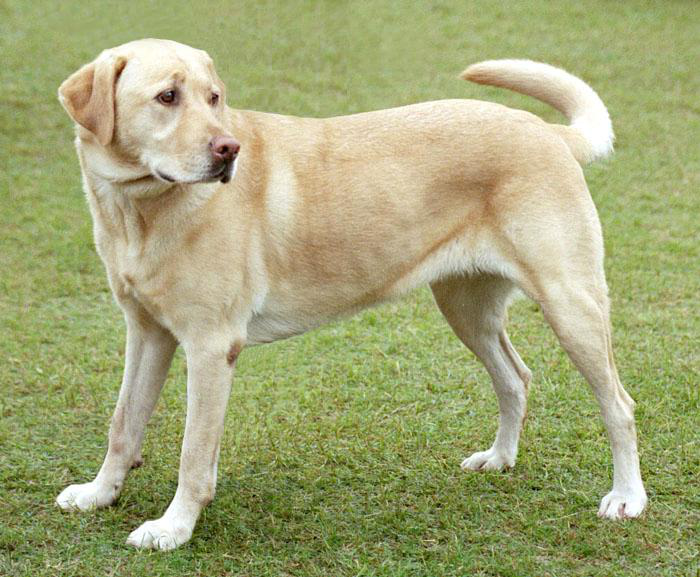

In [4]:
display(input_image)

In [5]:

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]                     
    )
])

input_tensor = preprocess(input_image)
if torch.cuda.is_available():
    input_tensor = Variable(input_tensor.cuda())
    
input_batch = input_tensor.unsqueeze(0)
out = model_vgg19(input_batch)

probabilities = torch.nn.functional.softmax(out[0], dim=0)
# print(probabilities)

### load the stanford dogs breeds labels / categories from the stanford_dogs_breeds_classes_final.txt file.>
<br>
More info about this txt file is in get_stanford_dogs_breeds_name-final.ipynb

In [6]:
with open("stanford_dogs_breeds_classes_final.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [7]:
predicted_breeds = []

top3_prob, top3_catid = torch.topk(probabilities, 3)
for i in range(top3_prob.size(0)):
    print('Predicted breed:', categories[top3_catid[i]], top3_prob[i].item()*100)
    predicted_breeds.append((categories[top3_catid[i]], top3_prob[i].item()*100))

Predicted breed: Labrador retriever 99.58696961402893
Predicted breed: golden retriever 0.23007066920399666
Predicted breed: Chesapeake Bay retriever 0.060010014567524195


In [8]:
# list to be used directly by the application (predicted_breed, probability)
predicted_breeds

[('Labrador retriever', 99.58696961402893),
 ('golden retriever', 0.23007066920399666),
 ('Chesapeake Bay retriever', 0.060010014567524195)]